X_train shape: (175, 15)
X_test shape: (44, 15)
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.40      0.25      0.31        24
           2       0.62      0.86      0.72        96
           3       0.44      0.15      0.22        27
           4       0.22      0.10      0.14        20

    accuracy                           0.59       175
   macro avg       0.54      0.47      0.48       175
weighted avg       0.53      0.59      0.53       175

Test Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.25      0.14      0.18         7
           2       0.55      0.70      0.62        23
           3       0.00      0.00      0.00         9
           4       0.25      0.25      0.25         4

    accuracy                           0.43        44
   macro avg       0.28   

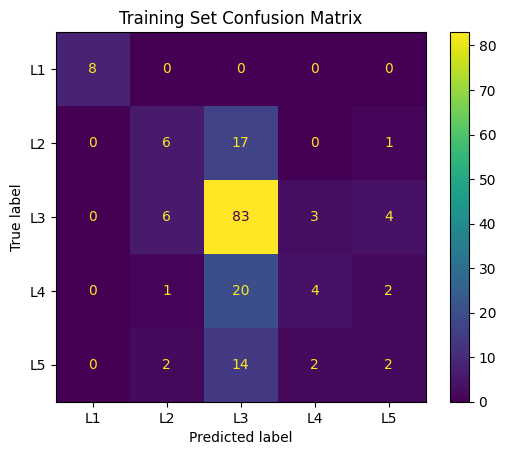

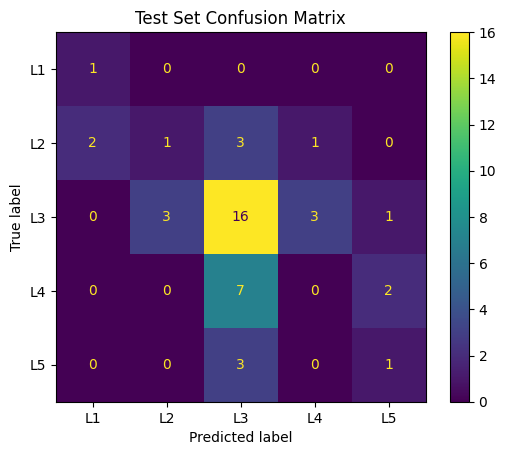

Inference Result: L1


In [2]:
# %%
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

# %%
def load_data(
                class_dict = {
                            "L1" : 0,
                            "L2" : 1,
                            "L3" : 2,
                            "L4" : 3,
                            "L5" : 4,
                            },
                precedure_dict = {
                                'Excellent' : 0,
                                'Modorate' : 1,
                                'low' : 2,
                                'Poor' : 3
                                },
                security_dict = {
                                'very high' : 0,
                                'High' : 1,
                                'low' : 2,
                                'Modorate' : 3,
                                'Low' : 4
                                },
                data_path = 'data/Financial_Data.xlsx' 
                ):
    data = pd.read_excel(data_path)
    data.columns = [col.strip() for col in data.columns]
    del data['Project ID']

    data['Classification Level'] = data['Classification Level'].map(class_dict)
    data['Procedure'] = data['Procedure'].map(precedure_dict)
    data['Security'] = data['Security'].map(security_dict)

    Y = data['Classification Level']
    X = data.drop('Classification Level', axis=1)

    return X, Y

# %%
X, Y = load_data()
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Create Imputer to fill missing values with median
imputer = SimpleImputer(strategy='median')

# Fit and Transform Training Data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform Testing Data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# %%
svc = SVC(kernel='linear', C=1, random_state=42)
svc.fit(X_train, Y_train)

# %%
P_train = svc.predict(X_train)
P_test = svc.predict(X_test)

cls_report_train = classification_report(Y_train, P_train)
cls_report_test = classification_report(Y_test, P_test)

print(f"Train Classification Report:\n{cls_report_train}")
print(f"Test Classification Report:\n{cls_report_test}")

# %%
cm_train = confusion_matrix(Y_train, P_train)
cm_test = confusion_matrix(Y_test, P_test)

ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['L1', 'L2', 'L3', 'L4', 'L5']).plot()
plt.title("Training Set Confusion Matrix")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['L1', 'L2', 'L3', 'L4', 'L5']).plot()
plt.title("Test Set Confusion Matrix")
plt.show()

# %%
with open('artifacts/financial_svc.pkl', 'wb') as f:
    pickle.dump(svc, f)

# %% [markdown]
# ### Inference

# %%
with open('artifacts/financial_svc.pkl', 'rb') as f:
    svc = pickle.load(f)

# %%
def inference_finance(sample_json):
    sample = pd.DataFrame(sample_json, index=[0])
    sample['Procedure'] = sample['Procedure'].map({
                                        'Excellent': 0,
                                        'Modorate': 1,
                                        'low': 2,
                                        'Poor': 3
                                    })
    sample['Security'] = sample['Security'].map({
                                        'very high': 0,
                                        'High': 1,
                                        'low': 2,
                                        'Modorate': 3,
                                        'Low': 4
                                    })
    pred = svc.predict(sample)[0]
    return {0: "L1", 1: "L2", 2: "L3", 3: "L4", 4: "L5"}[pred]

# %%
sample_json = {
    "Total": 1714544.0,
    "utility costs": 36000.0,
    "hardware cost": 545000.0,
    "Software costs": 733544.0,
    "Budget": 400000.0,
    "Additional Costs": 0.0,
    "man hours": 800.0,
    "Project Plan(weeks)": 12.0,
    "Procedure": "Modorate",
    "Security": "High",
    "Resourses": 4.0,
    "Investment": 1478635.53,
    "Resource Utilization Efficiency (%)": 91.84,
    "Plan Compliance (%)": 85.18,
    "Cost Per Resource": 428636.0
}

# %%
print("Inference Result:", inference_finance(sample_json))
